In [1]:
import json
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# New York

In [2]:
contents = urllib.request.urlopen(
    "https://data.covidactnow.org/latest/us/states/NY.OBSERVED_INTERVENTION.timeseries.json"
).read().decode('utf8')
nydata = json.loads(contents)

https://www.microcovid.org/paper/7-basic-method#step-two-underreporting-factor

We use these multipliers:
* If the percentage of positive tests is 5% or lower, we suggest a 6x underreporting factor.[4]
* If the percentage of positive tests is between 5% and 15%, we suggest a 8x factor.
* If the percentage of positive tests is greater than 15%, we suggest at least a 10x factor. This indicates dangerously little testing in your area compared to the number of infected people.


In [6]:
def get_underreport(el):
    # Assume a 10x multiplier if no test positivity ratio
    # is available. Mainly because missing data is early
    # during rapid growth phase for NY, Spain.
    if pd.isna(el):
        return 10 #6
    elif el <= 0.05:
        return 6
    elif el <= 0.15:
        return 8
    elif el > 0.15:
        return 10

In [61]:
metrics = pd.DataFrame(nydata['metricsTimeseries'])
metrics = metrics[['date', 'testPositivityRatio']]
metrics['date'] = pd.to_datetime(metrics['date'])
metrics['underreport_factor'] = metrics['testPositivityRatio'].apply(get_underreport)

cases = pd.DataFrame(nydata['actualsTimeseries'])
cases =  cases[['date', 'cumulativeConfirmedCases']]
cases['date'] = pd.to_datetime(cases['date'])
cases.sort_values(by='date', ascending=True)
cases.set_index('date', inplace=True)
cases['new_cases'] = cases['cumulativeConfirmedCases'].diff()
cases = cases.dropna()
cases['delay_factor'] = cases['new_cases'].pct_change(freq='7d').fillna(0)
# https://github.com/microcovid/microcovid/blob/main/src/data/calculate.ts#L152
# 2 day doubling time max, 2^(7/2) ~ 12 
cases['delay_factor'] = 1 + cases['delay_factor'].clip(lower=0, upper=12) #/100 12
cases.reset_index(drop=False, inplace=True)
cases = cases.dropna()

est_cases = metrics.merge(cases, on='date')
# Note: delay factor should not be counted in overall sum, because it's just as a shift.
# est_cases['estimated_cases'] = est_cases['new_cases'] * est_cases['underreport_factor'] * est_cases['delay_factor']
est_cases['estimated_cases'] = est_cases['new_cases'] * est_cases['underreport_factor']
est_cases

,date,testPositivityRatio,underreport_factor,cumulativeConfirmedCases,new_cases,delay_factor,estimated_cases
0,2020-03-02,NaN,10,1.0,0.0,1.000000,0.0
1,2020-03-03,NaN,10,2.0,1.0,1.000000,10.0
2,2020-03-04,NaN,10,11.0,9.0,1.000000,90.0
3,2020-03-05,0.363636,10,22.0,11.0,1.000000,110.0
4,2020-03-06,0.380282,10,44.0,22.0,1.000000,220.0
...,...,...,...,...,...,...,...
196,2020-09-14,0.009357,6,449658.0,586.0,1.116190,3516.0
197,2020-09-15,0.009469,6,450425.0,767.0,1.377020,4602.0
198,2020-09-16,0.009404,6,451078.0,653.0,1.139616,3918.0
199,2020-09-17,0.009405,6,451971.0,893.0,1.181217,5358.0


In [62]:
est_cases.describe()

,testPositivityRatio,underreport_factor,cumulativeConfirmedCases,new_cases,delay_factor,estimated_cases
count,198.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.107415,7.343284,315211.114428,2252.552239,1.859955,20305.920398
std,0.146855,1.745442,148036.436440,2885.438672,2.726659,29774.949537
min,0.007526,6.000000,1.000000,0.000000,1.000000,0.000000
25%,0.010027,6.000000,255932.000000,628.000000,1.000000,3774.000000
50%,0.012835,6.000000,384945.000000,779.000000,1.000000,4674.000000
75%,0.166691,10.000000,419081.000000,2524.000000,1.181118,20192.000000
max,0.507358,10.000000,452764.000000,12274.000000,13.000000,122740.000000


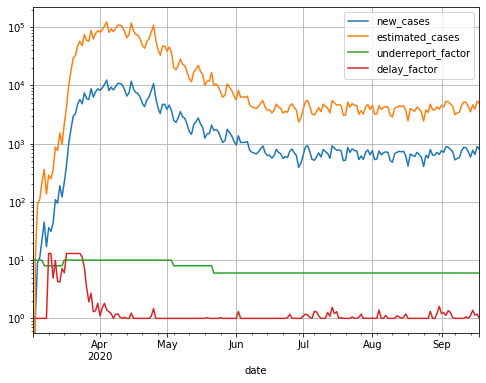

In [63]:
est_cases.plot(x='date', y=['new_cases', 'estimated_cases', 'underreport_factor', 'delay_factor'],
    kind='line', grid=True, logy=True, figsize=(8,6))

In [64]:
# Just assume April 23 was the end date, even though that's when it was reported
total_observed_cases = est_cases[est_cases['date'] < '2020-04-23']['new_cases'].sum()
total_estimated_cases = est_cases[est_cases['date'] < '2020-04-23']['estimated_cases'].sum()
pop = nydata['population']
print('Observed infection rate:', total_observed_cases/pop)
print('Estimated infection rate:', total_estimated_cases/pop)

Observed infection rate: 0.013446895403880041
Estimated infection rate: 0.13439822148757238


New York state did a preliminary [seroprevalence study](https://twitter.com/NYGovCuomo/status/1253352837255438338) completed on April 23rd that estimated a New York City infection rate of `21.2%` and a statewide rate of `13.9%`. The multiplier approach does really well, estimating `13.4%` seroprevalence at that date. This was early in pandemic, how well does this approach work now that some locations have built up more testing capacity?

# Spain

In [33]:
spainsource = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [65]:
spaindata = spainsource.copy()
spaindata = spaindata[spaindata.iso_code == 'ESP']
spaindata = spaindata[['date', 'new_cases', 'positive_rate']]
spaindata['date'] = pd.to_datetime(spaindata['date'])
spaindata.set_index('date', inplace=True)

spaindata['underreport_factor'] = spaindata['positive_rate'].apply(get_underreport)
spaindata['delay_factor'] = spaindata['new_cases'].pct_change(freq='7d').fillna(0)
# https://github.com/microcovid/microcovid/blob/main/src/data/calculate.ts#L152
# 2 day doubling time max, 2^(7/2) ~ 12 
spaindata['delay_factor'] = 1 + spaindata['delay_factor'].clip(lower=0, upper=12) #/100 
# Note: delay factor should not be counted in overall sum, because it's just a shift.
# spaindata['estimated_cases'] = spaindata['new_cases']*spaindata['underreport_factor']*spaindata['delay_factor']
spaindata['estimated_cases'] = spaindata['new_cases']*spaindata['underreport_factor']
spaindata.reset_index(drop=False, inplace=True)
spaindata

,date,new_cases,positive_rate,underreport_factor,delay_factor,estimated_cases
0,2019-12-31,0.0,NaN,10,1.000000,0.0
1,2020-01-01,0.0,NaN,10,1.000000,0.0
2,2020-01-02,0.0,NaN,10,1.000000,0.0
3,2020-01-03,0.0,NaN,10,1.000000,0.0
4,2020-01-04,0.0,NaN,10,1.000000,0.0
...,...,...,...,...,...,...
259,2020-09-15,9437.0,NaN,10,1.052767,94370.0
260,2020-09-16,11193.0,NaN,10,1.262463,111930.0
261,2020-09-17,11291.0,NaN,10,1.048959,112910.0
262,2020-09-18,14389.0,NaN,10,1.181072,143890.0


In [66]:
spaindata.describe()

,new_cases,positive_rate,underreport_factor,delay_factor,estimated_cases
count,264.000000,148.000000,264.000000,264.000000,264.000000
mean,2424.393939,0.048939,8.204545,2.130417,20740.787879
std,4161.104142,0.048946,1.788168,2.997197,35687.548899
min,-713.000000,0.008000,6.000000,1.000000,-7130.000000
25%,0.000000,0.013750,6.000000,1.000000,0.000000
50%,455.000000,0.027500,8.000000,1.000000,2844.000000
75%,3233.000000,0.076000,10.000000,1.376193,29247.500000
max,27404.000000,0.278000,10.000000,13.000000,219232.000000


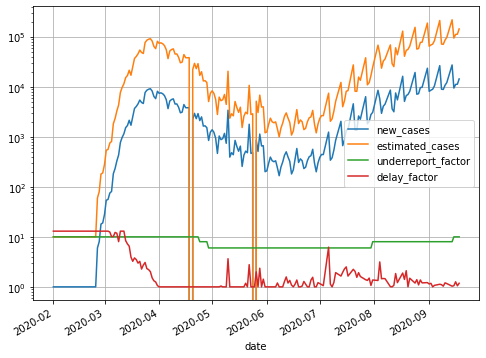

In [67]:
# Get rid of zero days, for plot
spainplot=spaindata.copy()
spainplot = spainplot[spainplot['new_cases'] != 0]

# A bit of a mess because not smoothed, but multiplier appears to be working.
spainplot.plot(x='date', y=['new_cases', 'estimated_cases', 'underreport_factor', 'delay_factor'],
    kind='line', grid=True, logy=True, figsize=(8,6))

In [56]:
# https://en.wikipedia.org/wiki/Demographics_of_Spain
spainpop = 47007367
spaincases = spaindata[spaindata['date'] <= '2020-05-13']['new_cases'].sum()
spainestimates = spaindata[spaindata['date'] <= '2020-05-13']['estimated_cases'].sum()
print('Observed infection rate:', spaincases/spainpop)
print('Estimated infection rate:', spainestimates/spainpop)

Observed infection rate: 0.00486500339404247
Estimated infection rate: 0.04692102835710837


Based on the total reported count, `0.48%` of the nation has been infected as of 5/13/2020, while [seroprevalence](https://www.reuters.com/article/us-health-coronavirus-spain-study/spanish-antibody-study-points-to-5-of-population-affected-by-coronavirus-idUSKBN22P2RP) [says](https://www.vox.com/2020/5/16/21259492/covid-antibodies-spain-serology-study-coronavirus-immunity) `5%`. So there's a 10x undercount of official cases. The model predicts around `4.7%` of Spain has been infected (`3.05%` if you fill in missing early values with 6x multiplier instead of 10x). Overall this seems to perform really well, but I still wonder if it will undercount in places with really good testing capacity? Or will places with good testing capacity not tend to have large outbreaks?  